# Классификация изображений жителей Спрингфилда
В данном задании вам предстоит осуществить путешевствие в мир Спрингфилда, где вы сможете познакомиться со всеми любимыми персонажами Симпсонов.  
Основным заданием будет обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда.  
https://www.kaggle.com/competitions/journey-springfield

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import PIL
print(PIL.__version__)

8.4.0


In [6]:
!ls /content/gdrive/

MyDrive


In [7]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Apr 12 20:35 /content/gdrive/MyDrive/journey-springfield.zip


In [8]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [9]:
!ls -1

characters_illustration.png
drive
gdrive
sample_data
sample_submission.csv
testset
train


In [10]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [11]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [12]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    !nvidia-smi

CUDA is available!  Training on GPU ...
Thu Apr 13 09:00:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [14]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [15]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
      
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            self.transform = transform

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
      
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на изображения в датасете

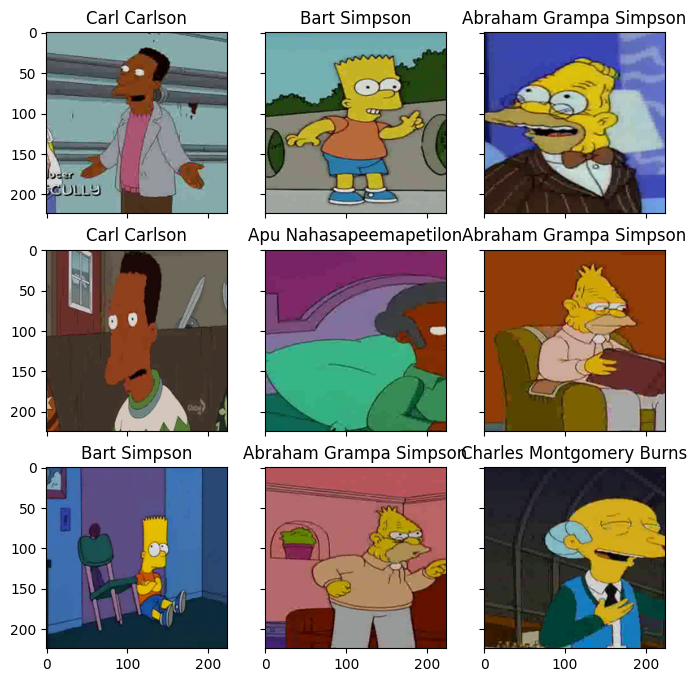

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


+ Подобраны количество эпох и размер батча
+ Добавлен BatchNorm

In [22]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) 
                
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)     

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [23]:
def fit_epoch(model, train_loader, optimizer, criterion):
  run_correct = 0 
  run_loss = 0 
  processed_data = 0
  model.train()
  for inputs, labels in train_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(output, 1)
    run_loss += loss.item() * inputs.size(0)
    run_correct += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = run_loss / processed_data
  train_acc = run_correct.cpu().numpy() / processed_data
  return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
  if sampler is None:
    train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
  else:
    train_loader = DataLoader(train_files, batch_size = batch_size, sampler = sampler)
  val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

  history = []
  log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
  val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

  with tqdm(desc = "epoch", total = epochs) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
      print("loss", train_loss)
            
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))
          
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      
  return history


In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [28]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [29]:
torch.cuda.empty_cache()

In [30]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=8)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.8043913385034163


epoch:  17%|█▋        | 1/6 [03:05<15:26, 185.25s/it]


Epoch: 001 train_loss: 1.8044 train_accuracy: 0.5092  val_loss: 1.2760 val_accuracy: 0.6572
loss 1.098061718217992


epoch:  33%|███▎      | 2/6 [05:59<11:56, 179.06s/it]


Epoch: 002 train_loss: 1.0981 train_accuracy: 0.6943  val_loss: 1.0122 val_accuracy: 0.7285
loss 0.823649107160762


epoch:  50%|█████     | 3/6 [08:50<08:44, 174.99s/it]


Epoch: 003 train_loss: 0.8236 train_accuracy: 0.7655  val_loss: 0.8251 val_accuracy: 0.7768
loss 0.6430144873603441


epoch:  67%|██████▋   | 4/6 [11:39<05:45, 172.94s/it]


Epoch: 004 train_loss: 0.6430 train_accuracy: 0.8167  val_loss: 0.7973 val_accuracy: 0.7933
loss 0.5240716704626176


epoch:  83%|████████▎ | 5/6 [14:28<02:51, 171.28s/it]


Epoch: 005 train_loss: 0.5241 train_accuracy: 0.8485  val_loss: 0.7548 val_accuracy: 0.8030
loss 0.42740374915302987


epoch: 100%|██████████| 6/6 [17:17<00:00, 172.98s/it]


Epoch: 006 train_loss: 0.4274 train_accuracy: 0.8748  val_loss: 0.7206 val_accuracy: 0.8181


Построим кривые обучения

In [31]:
loss, acc, val_loss, val_acc = zip(*history)

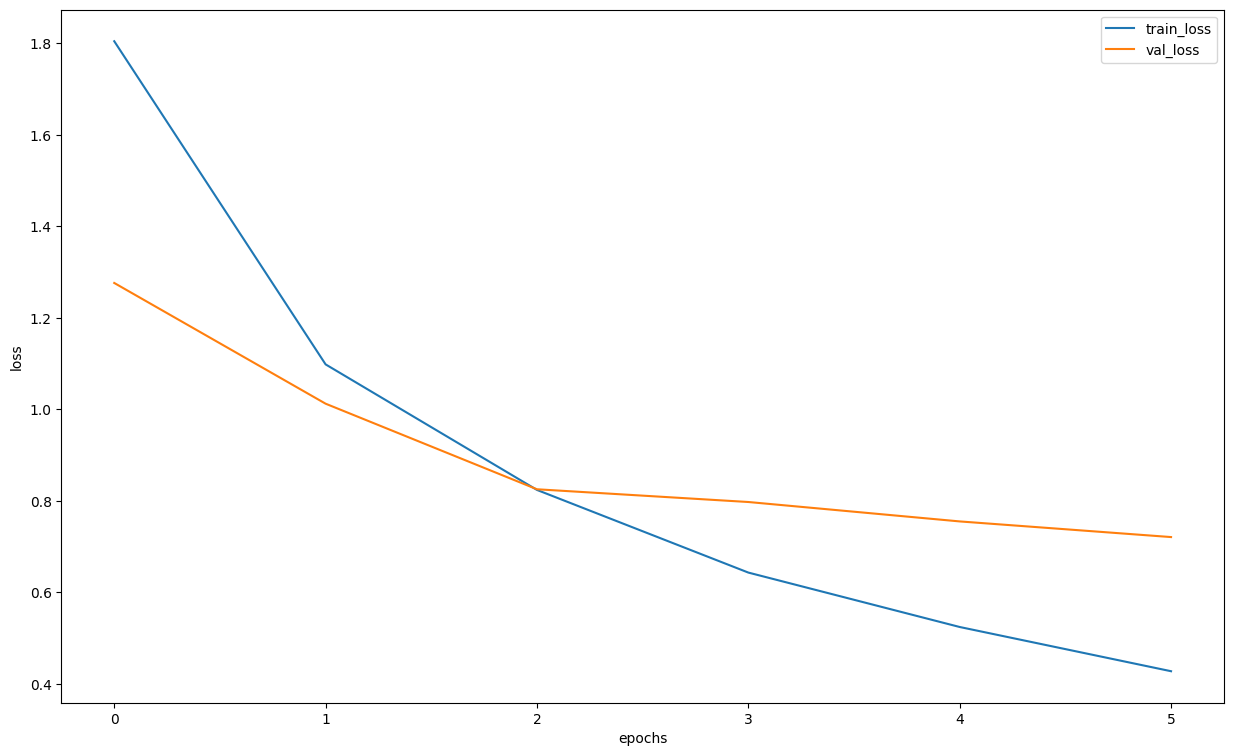

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### AlexNet
Используем предобученную сеть AlexNet и сравним результаты

In [33]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))
transfer_model = models.alexnet(pretrained=True)
transfer_model
transfer_model.classifier = nn.Sequential(
            nn.Linear(9216, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, n_classes),
        )

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 91.0MB/s]


In [34]:
transfer_model.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [35]:
history = train(train_dataset, val_dataset, model=transfer_model, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.3749733209359403


epoch:  12%|█▎        | 1/8 [02:39<18:35, 159.32s/it]


Epoch: 001 train_loss: 1.3750 train_accuracy: 0.6428  val_loss: 0.6266 val_accuracy: 0.8475
loss 0.49708316576762585


epoch:  25%|██▌       | 2/8 [05:18<15:54, 159.09s/it]


Epoch: 002 train_loss: 0.4971 train_accuracy: 0.8709  val_loss: 0.4212 val_accuracy: 0.8898
loss 0.2566710242162625


epoch:  38%|███▊      | 3/8 [07:56<13:13, 158.64s/it]


Epoch: 003 train_loss: 0.2567 train_accuracy: 0.9316  val_loss: 0.5521 val_accuracy: 0.8714
loss 0.16101608855878938


epoch:  50%|█████     | 4/8 [10:35<10:35, 158.92s/it]


Epoch: 004 train_loss: 0.1610 train_accuracy: 0.9546  val_loss: 0.3913 val_accuracy: 0.9037
loss 0.14118284007927226


epoch:  62%|██████▎   | 5/8 [13:14<07:56, 158.91s/it]


Epoch: 005 train_loss: 0.1412 train_accuracy: 0.9629  val_loss: 0.4747 val_accuracy: 0.8955
loss 0.10285845476498277


epoch:  75%|███████▌  | 6/8 [15:52<05:17, 158.68s/it]


Epoch: 006 train_loss: 0.1029 train_accuracy: 0.9711  val_loss: 0.4082 val_accuracy: 0.9133
loss 0.10907597081894703


epoch:  88%|████████▊ | 7/8 [18:32<02:38, 158.95s/it]


Epoch: 007 train_loss: 0.1091 train_accuracy: 0.9695  val_loss: 0.3916 val_accuracy: 0.9175
loss 0.08512196203627187


epoch: 100%|██████████| 8/8 [21:17<00:00, 159.70s/it]


Epoch: 008 train_loss: 0.0851 train_accuracy: 0.9785  val_loss: 0.5330 val_accuracy: 0.8884


### Submit на Kaggle

In [36]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [37]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(transfer_model, ex_img.unsqueeze(0))

In [38]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(transfer_model, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
print(actual_labels)
print(preds_class)
print(y_pred)

[6, 2, 6, 0, 0, 0, 4, 0, 4, 2, 2, 4, 0, 5, 4, 6, 2, 6, 4, 6]
['charles_montgomery_burns', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'bart_simpson', 'abraham_grampa_simpson', 'carl_carlson', 'bart_simpson', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'bart_simpson', 'charles_montgomery_burns']
[6 2 6 0 0 0 4 0 4 2 2 4 0 5 4 6 2 6 4 6]


In [44]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(transfer_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [45]:
! ls 

characters_illustration.png  gdrive		sample_data	       testset
drive			     label_encoder.pkl	sample_submission.csv  train


In [46]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)

Сабмит на Kaggle с предобученной AlexNet набрал 0.9458